In [1]:
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from tabulate import tabulate
from src import camvid
from src import evaluate
from src import predict
from src import predict_video
from src import segnet
from src.callbacks import PlotMetrics
from src.utils import history_to_results
from src.wrappers import MonteCarlo
%matplotlib inline

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
weights_file = 'models/BayesianSegNet-CamVid11.h5'

In [3]:
# the batch size for training the network
batch_size = 8
# the size to crop images to
crop_size = (352, 480)

# Training

In [4]:
camvid11 = camvid.CamVid(
    mapping=camvid.load_mapping(), 
    target_size=(360, 480), 
    crop_size=crop_size, 
    batch_size=batch_size,
    ignored_labels=['Void'],
)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


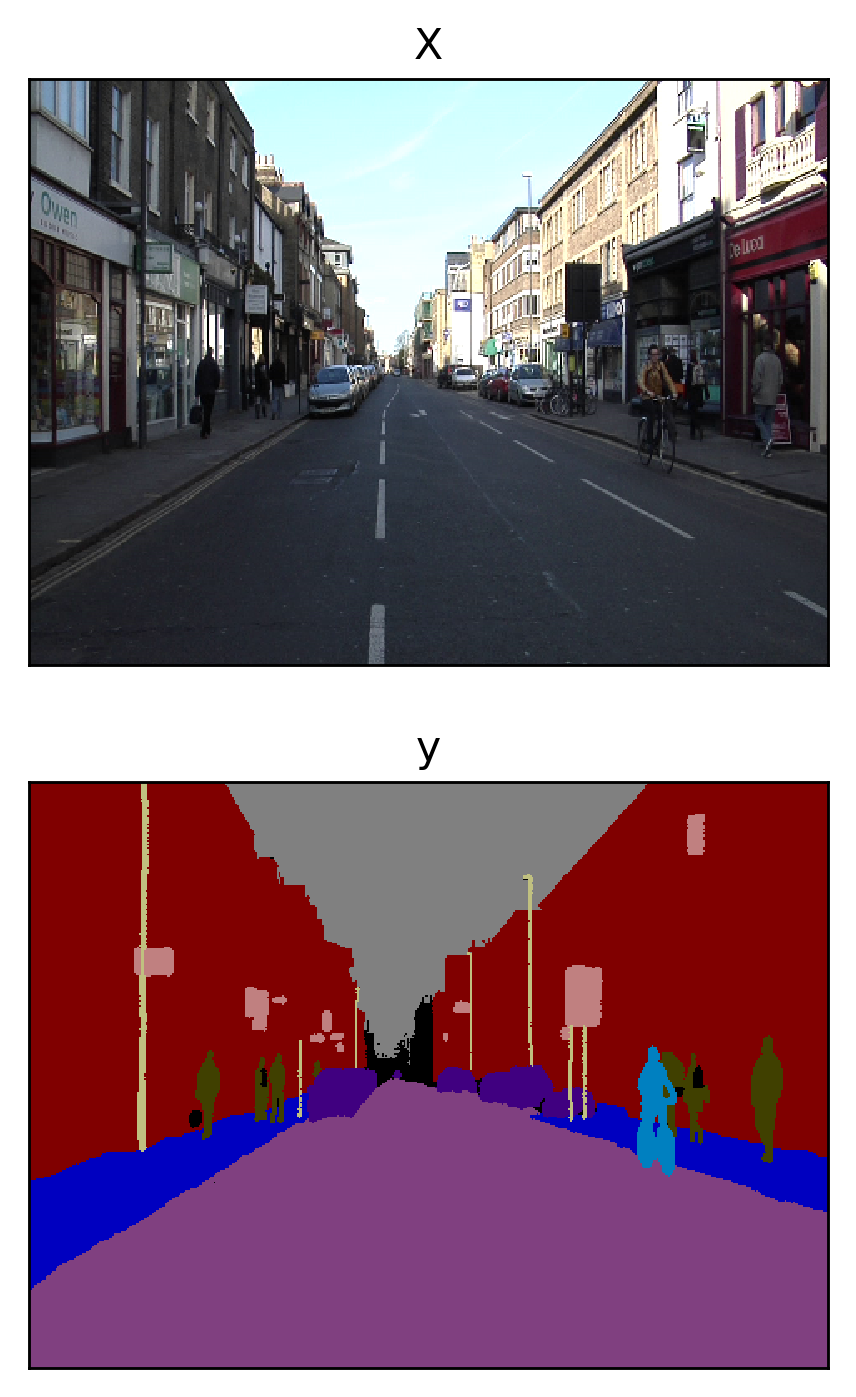

In [5]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
_ = camvid.plot(X=X[0], y=y[0], order=['X', 'y'])

In [6]:
# build the model for the image shape and number of labels
model = segnet.segnet((*crop_size, 3), camvid11.n, 
    class_weights=camvid11.class_weights,
    dropout_rate=0.5,
)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SegNet_input (InputLayer)    (None, 352, 480, 3)       0         
_________________________________________________________________
pixel_norm (Lambda)          (None, 352, 480, 3)       0         
_________________________________________________________________
local_contrast_normalization (None, 352, 480, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 352, 480, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 352, 480, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 352, 480, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 352, 480, 64)      36928     
__________

In [7]:
# create the callbacks for the training procedure
callbacks = [
    EarlyStopping(monitor='loss', patience=50),
    LearningRateScheduler(lambda _, lr: 0.95 * lr),
    ModelCheckpoint(weights_file, 
        monitor='val_categorical_accuracy', 
        save_best_only=True, 
        save_weights_only=True, 
        mode='max'
    ),
    PlotMetrics(),
]

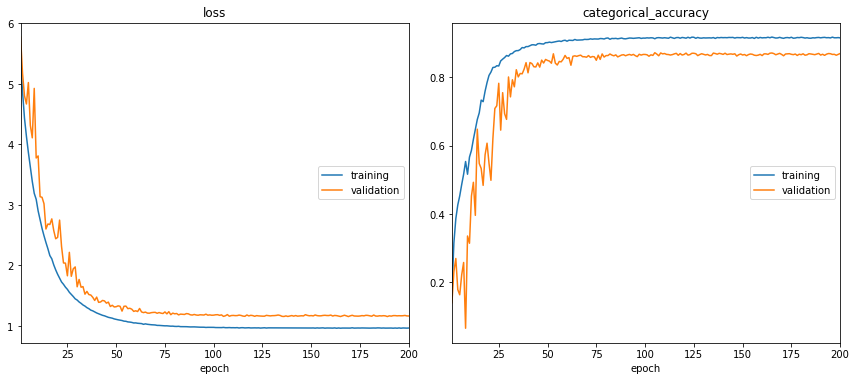

In [8]:
# fit the model with the data. divide the steps per epoch by the 
# batch size (which is 3 in this case)
history = model.fit_generator(generators['train'],
    epochs=200,
    steps_per_epoch=int(367 / batch_size),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=0
)

In [9]:
history_to_results(history)

train       val
categorical_accuracy  0.915727  0.869921
loss                  0.966841  1.165638

# Test Metrics

In [10]:
model.load_weights(weights_file)

In [11]:
# wrap the model with the test time Monte Carlo
model = MonteCarlo(model, 50)

In [12]:
metrics = evaluate.evaluate(model, generators['test'], 233,
    mask=camvid11.class_mask, 
    label_map=camvid11.label_to_discrete_map
)
metrics.to_csv(weights_file + '.csv')
metrics

100%|██████████| 233/233 [14:18<00:00,  3.68s/step]


Test
Accuracy                 0.868758
Mean Per Class Accuracy  0.767013
Mean I/U                 0.550385
Bicyclist                0.369756
Building                 0.709912
Car                      0.675461
Column_Pole              0.207310
Fence                    0.394083
Pedestrian               0.326561
Road                     0.885637
Sidewalk                 0.724150
SignSymbol               0.174897
Sky                      0.886314
VegetationMisc           0.700158

In [13]:
print(tabulate(metrics, tablefmt='pipe', headers=('Metric', 'Value')))

| Metric                  |    Value |
|:------------------------|---------:|
| Accuracy                | 0.868758 |
| Mean Per Class Accuracy | 0.767013 |
| Mean I/U                | 0.550385 |
| Bicyclist               | 0.369756 |
| Building                | 0.709912 |
| Car                     | 0.675461 |
| Column_Pole             | 0.20731  |
| Fence                   | 0.394083 |
| Pedestrian              | 0.326561 |
| Road                    | 0.885637 |
| Sidewalk                | 0.72415  |
| SignSymbol              | 0.174897 |
| Sky                     | 0.886314 |
| VegetationMisc          | 0.700158 |


# Qualitative Results

### Train Results

In [14]:
X, y, p, s = predict.predict_epistemic(model, generators['train'], camvid11)

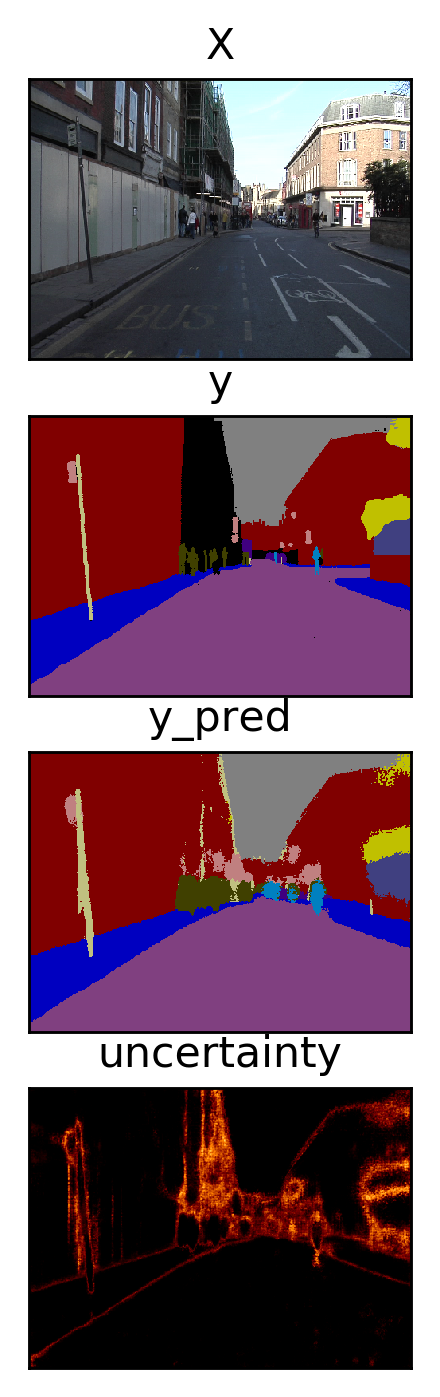

In [15]:
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])

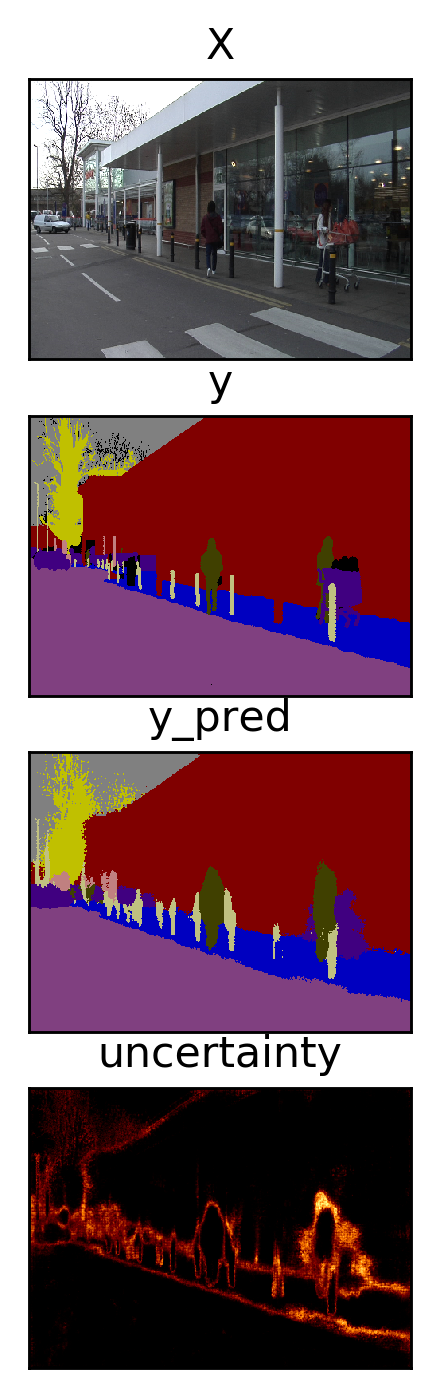

In [16]:
_ = camvid.plot(X=X[1], y=y[1], y_pred=p[1], uncertainty=s[1], order=['X', 'y', 'y_pred', 'uncertainty'])

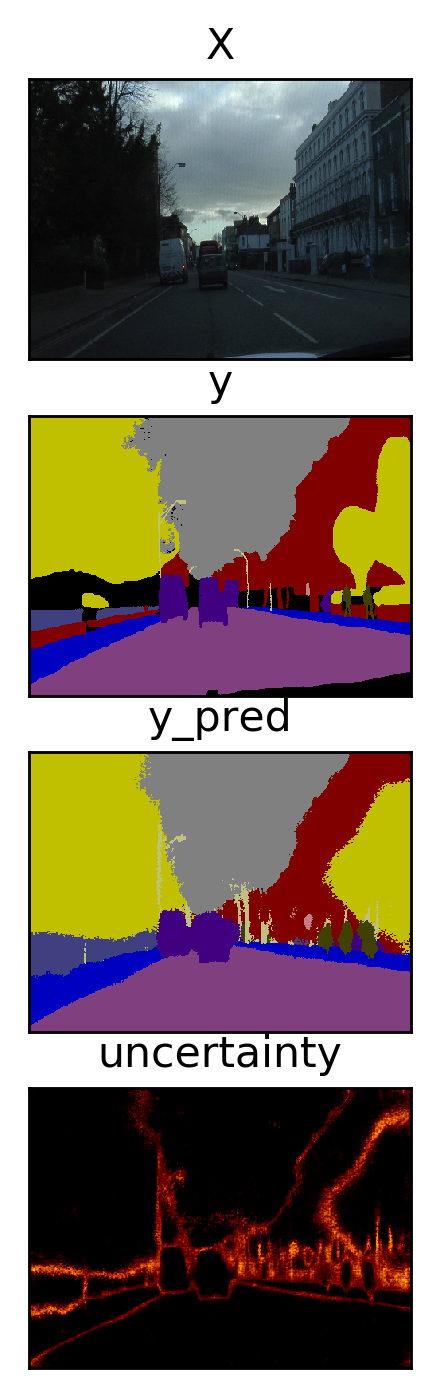

In [17]:
_ = camvid.plot(X=X[2], y=y[2], y_pred=p[2], uncertainty=s[2], order=['X', 'y', 'y_pred', 'uncertainty'])

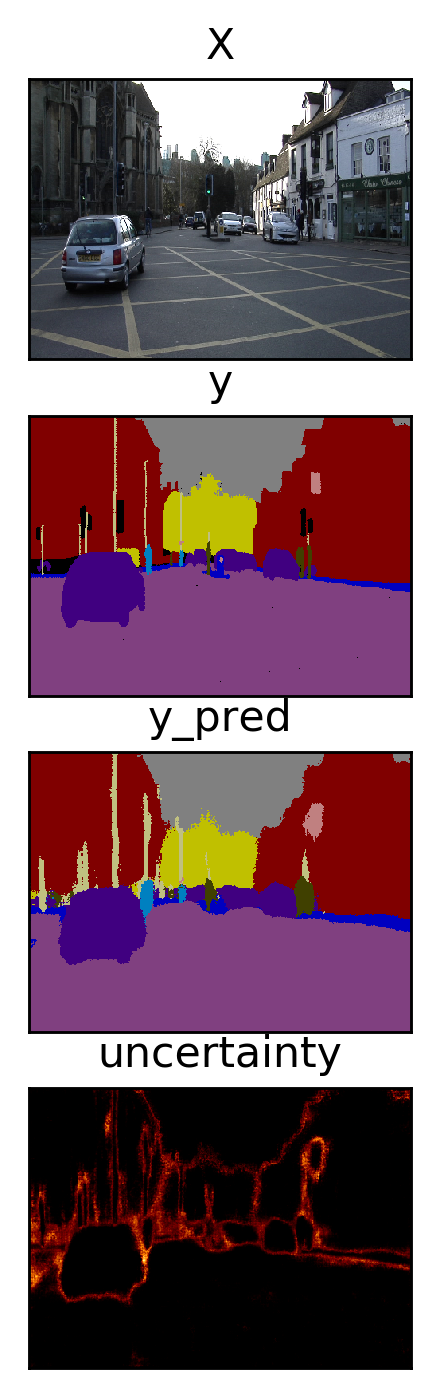

In [18]:
_ = camvid.plot(X=X[3], y=y[3], y_pred=p[3], uncertainty=s[3], order=['X', 'y', 'y_pred', 'uncertainty'])

### Validation Results

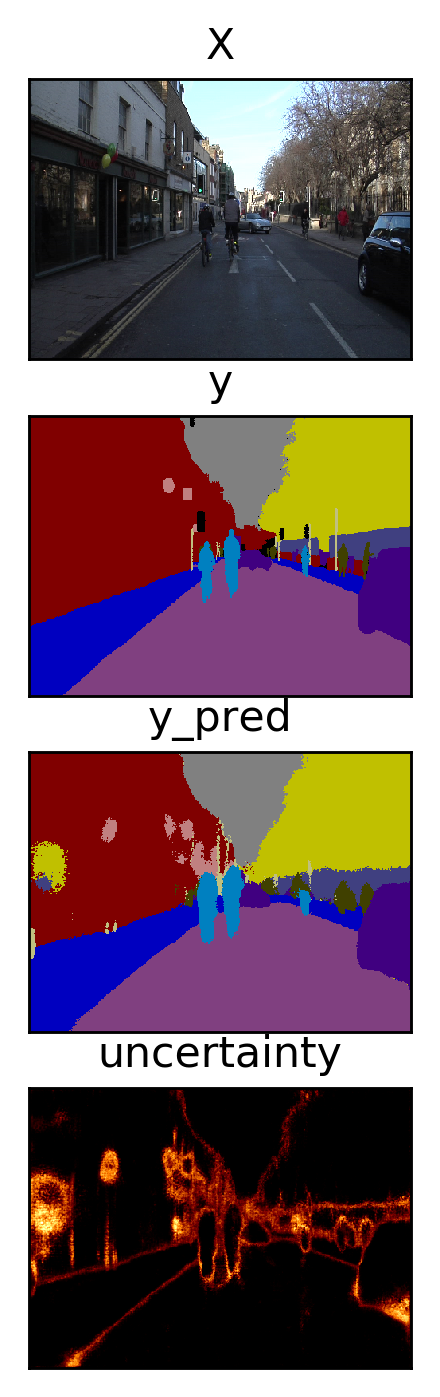

In [19]:
X, y, p, s = predict.predict_epistemic(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])

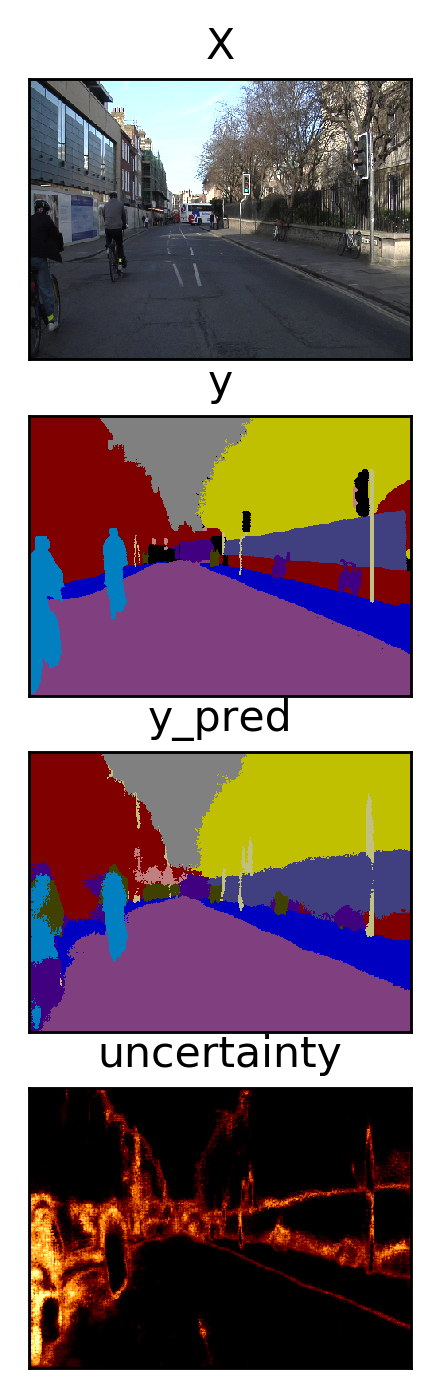

In [20]:
X, y, p, s = predict.predict_epistemic(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])

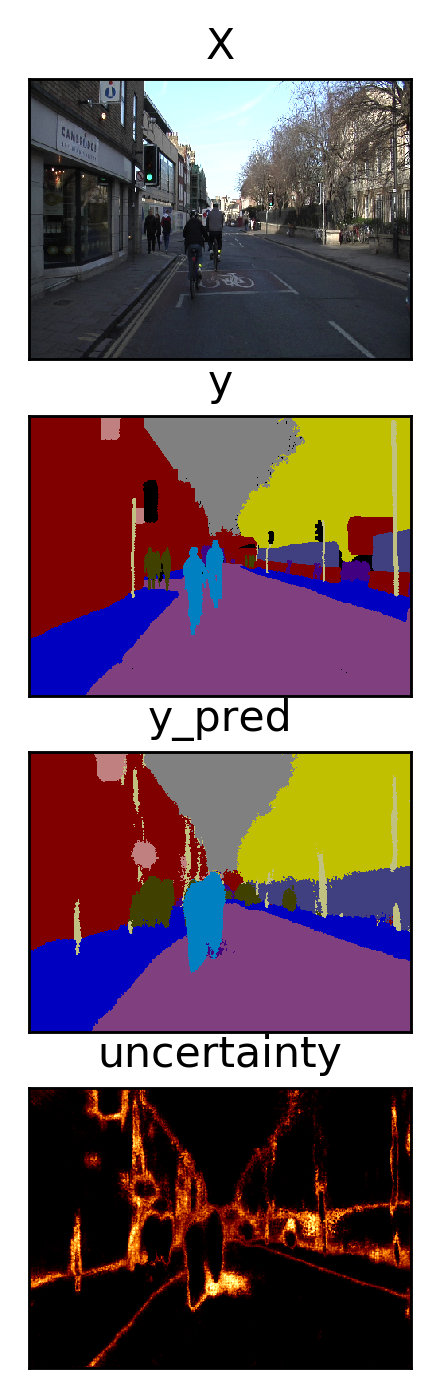

In [21]:
X, y, p, s = predict.predict_epistemic(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])

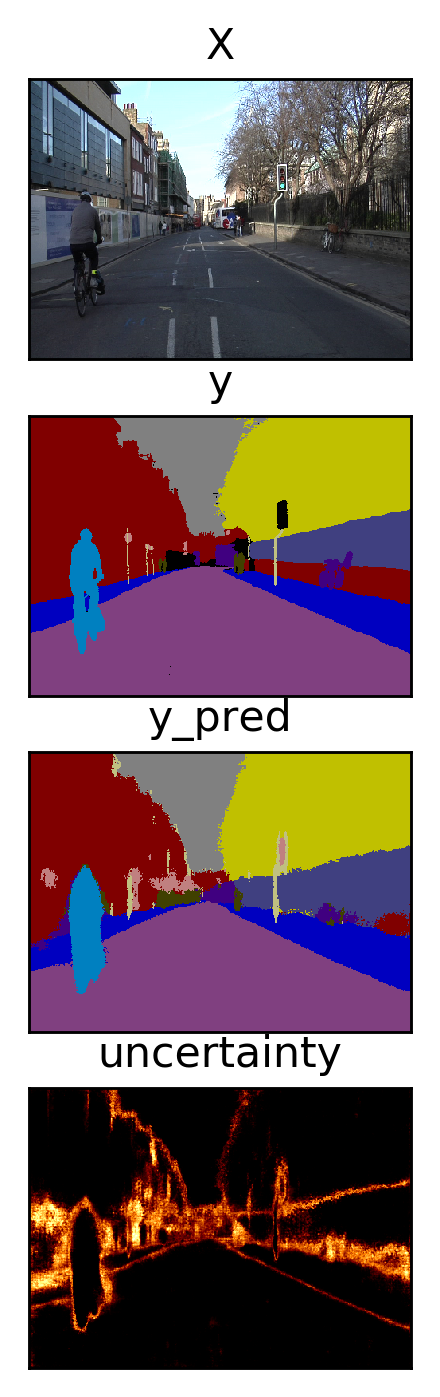

In [22]:
X, y, p, s = predict.predict_epistemic(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])

### Test Results

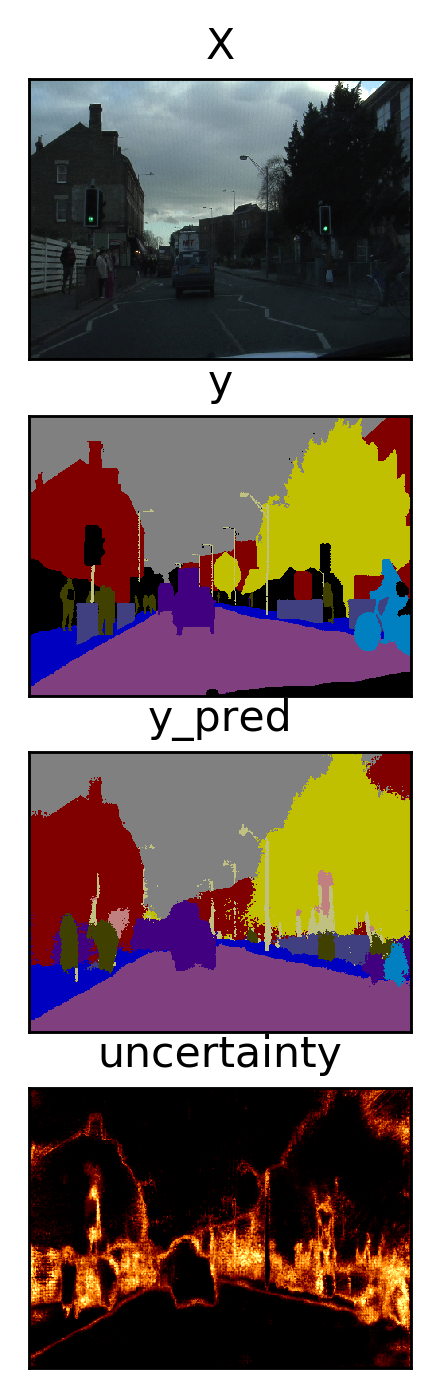

In [23]:
X, y, p, s = predict.predict_epistemic(model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])
fig.savefig('img/bayesian-segnet/0.png', transparent=True, bbox_inches='tight')

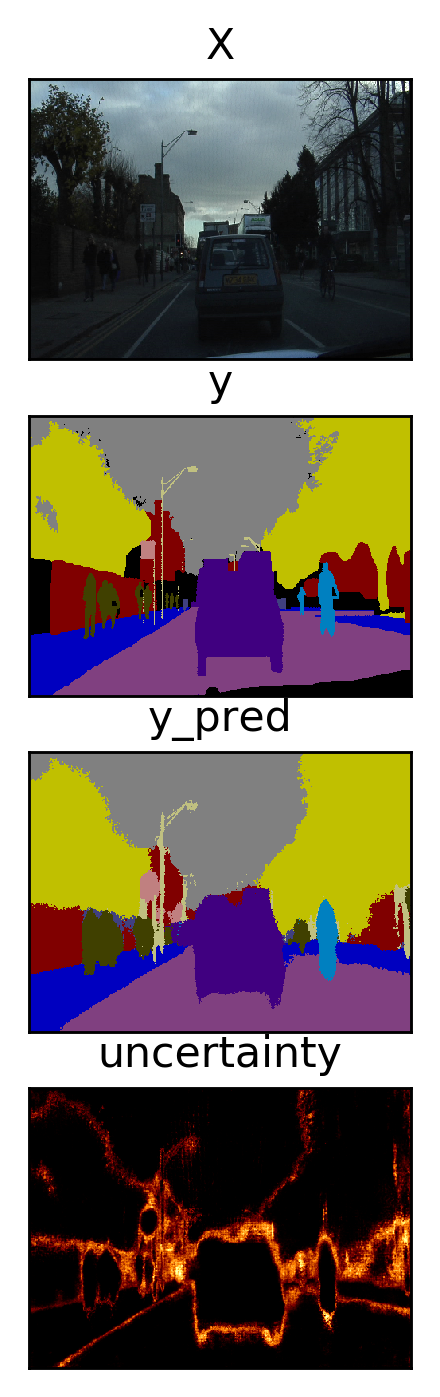

In [24]:
X, y, p, s = predict.predict_epistemic(model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])
fig.savefig('img/bayesian-segnet/1.png', transparent=True, bbox_inches='tight')

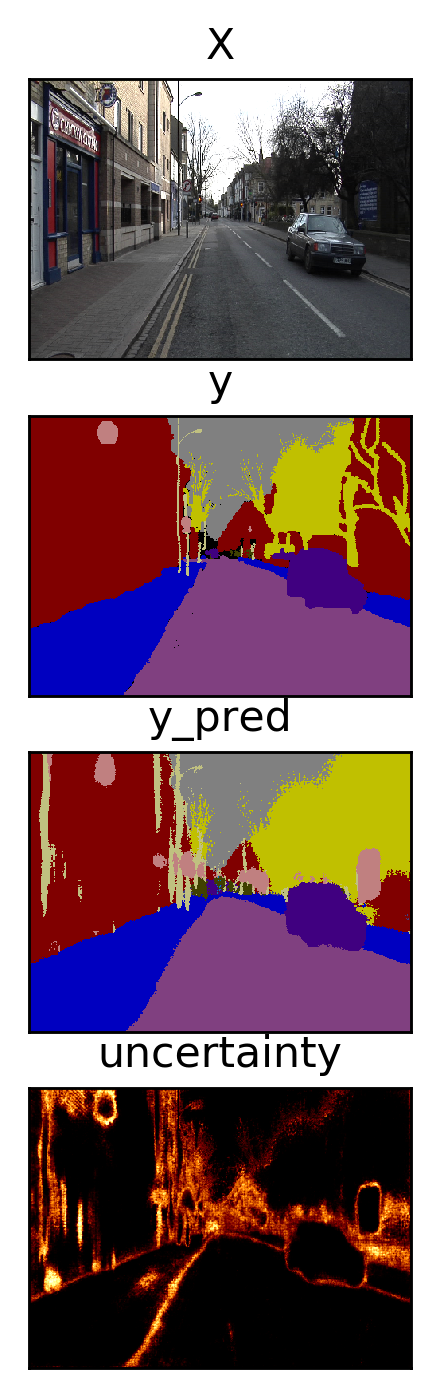

In [25]:
X, y, p, s = predict.predict_epistemic(model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])
fig.savefig('img/bayesian-segnet/2.png', transparent=True, bbox_inches='tight')

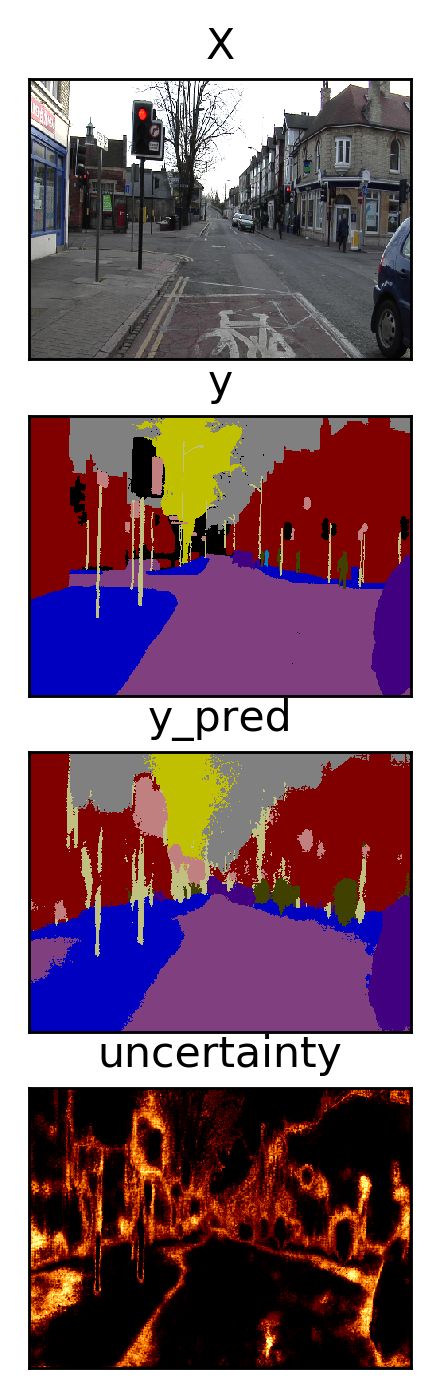

In [26]:
X, y, p, s = predict.predict_epistemic(model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])
fig.savefig('img/bayesian-segnet/3.png', transparent=True, bbox_inches='tight')

# Video

In [27]:
model.simulations = 7

In [28]:
video_file = '0005VD.mp4'
video_path = camvid.videos.abs_path(video_file)
out_path = 'img/bayesian-segnet/{}'.format(video_file)

In [29]:
predict_video.predict_video(video_path, out_path, camvid11, model, predict.predict_epistemic)

100%|██████████| 6600/6600 [1:03:57<00:00,  1.72it/s]
